# Baseline model for urban sound tagging

In this notebook, you will build and train a baseline model to perform urban sound tagging with [PyTorch](https://pytorch.org/).

Similar to the original [baseline of the DCASE 2019 Challenge - Task 5](https://github.com/sonyc-project/urban-sound-tagging-baseline) presented in ([Cartwright et al., 2019)](https://dcase.community/documents/workshop2019/proceedings/DCASE2019Workshop_Cartwright_4.pdf), this baseline is a simple multi-label logistic regression model, i.e., a separate binary logistic regression model for each of the 8 classes in the SONYC-UST dataset.

The model takes [VGGish](https://github.com/tensorflow/models/tree/master/research/audioset/vggish) embeddings as input, which originally returns a 128-dimensional vector given an audio signal of 0.96 seconds. The SONYC-UST audio data samples being 10-second long, we simply compute VGGish embeddings on short nonoverlapping frames and pool them temporally before feeding the resulting representation to the multi-label logistic regression model.

VGGish was trained on [AudioSet](https://github.com/tensorflow/models/tree/master/research/audioset), a dataset of over 2 million human-labeled 10-second YouTube video soundtracks, with labels taken from an ontology of more than 600 audio event classes. This represents more than 5 thousand hours of audio.

The baseline model is trained to minimize the binary cross-entropy loss, using the Adam optimizer. Early stopping on the validation set is used to mitigate overfitting.

**Before working on the rest of this notebook, take some time to browse the above references about VGGish, Audioset, and the DCASE 2019 Challenge - Task 5 baseline.**

## Environment setup

In [1]:
SEED = 0
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
import torch.nn as nn
from torch.utils.data.dataset import Dataset

import os
import shutil

import pandas as pd
import oyaml as yaml
import pytz
import datetime
import json
from tqdm import tqdm

from utils import get_file_targets, get_subset_split, generate_output_file, predict
from metrics import evaluate, micro_averaged_auprc, macro_averaged_auprc

In [2]:
from paths import (root_path, ust_data_dir, dataset_dir, annotation_file, 
                   taxonomy_file, log_mel_spec_dir)

os.chdir(root_path)

model_name = 'baseline'

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.datetime.now(tz_Paris)
timestamp = datetime_Paris.strftime("%Y-%m-%d-%Hh%Mm%Ss")

exp_id = model_name + '_' + timestamp

output_dir = os.path.join(root_path, 'data/output', exp_id)
os.makedirs(output_dir)

print(exp_id)

baseline_2024-11-27-12h35m18s


If a GPU is available we will use it.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Define parameters


In the following cell, you have to set several hyperparameters of the learning algorithm.

In [4]:
batch_size = 128
num_epochs = 100
learning_rate = 1e-2
patience = 20

In [5]:
# save parameters to disk
params = {'annotation_file': annotation_file,
          'taxonomy_file': taxonomy_file,
          'exp_id': exp_id,
          'log_mel_spec_dir': log_mel_spec_dir,
          'learning_rate': learning_rate,
          'batch_size': batch_size,
          'batch_size': batch_size,
          'num_epochs': num_epochs,
          'patience': patience}

kwarg_file = os.path.join(output_dir, "hyper_params.json")
with open(kwarg_file, 'w') as f:
    json.dump(params, f, indent=2)

## Data

### Annotations and taxonomy

In [6]:
# Create a Pandas DataFrame from the annotation CSV file
annotation_data = pd.read_csv(annotation_file).sort_values('audio_filename')

# List of all audio files
file_list = annotation_data['audio_filename'].unique().tolist()

# Load taxonomy
with open(taxonomy_file, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

# get list of labels from taxonomy
labels = ["_".join([str(k), v]) for k,v in taxonomy['coarse'].items()]

# list of one-hot encoded labels for all audio files
target_list = get_file_targets(annotation_data, labels)

# list of idices for the training, validation and test subsets
train_file_idxs, val_file_idxs, test_file_idxs = get_subset_split(annotation_data)

# number of classes
n_classes = len(labels)

### Log-Mel spectrograms

In [7]:
how_saved = 'global' # 'individual' or 'global'

if how_saved == 'global':
  log_mel_spec_list = list(np.load(os.path.join(log_mel_spec_dir, 'data.npy')))

elif how_saved == 'individual':
  # Create a list of log-Mel spectrograms of size 998 frames × 64 Mel-frequency
  log_mel_spec_list = []
  for idx, filename in enumerate(file_list):
      clear_output(wait=True)

      log_mel_path = os.path.join(log_mel_spec_dir, os.path.splitext(filename)[0] + '.npy')
      log_mel_spec = np.load(log_mel_path)
      log_mel_spec_list.append(log_mel_spec)

      print('({}/{})'.format(idx+1, len(file_list)))


In [8]:
# Create training and validation data loaders

class MyDataset(Dataset):
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __getitem__(self, index):
		x = torch.Tensor(self.x[index]).to(device)
		y = torch.Tensor(self.y[index]).to(device)
		return (x, y)

	def __len__(self):
		count = self.x.shape[0]
		return count

train_x = []
train_y = []
for idx in train_file_idxs:
    train_x.append(log_mel_spec_list[idx])
    train_y.append(target_list[idx])

perm_train_idxs = np.random.permutation(len(train_x))

train_x = np.array(train_x)[perm_train_idxs]
train_y = np.array(train_y)[perm_train_idxs]

val_x = []
val_y = []
for idx in val_file_idxs:
    val_x.append(log_mel_spec_list[idx])
    val_y.append(target_list[idx])

perm_val_idxs = np.random.permutation(len(val_x))

val_x = np.array(val_x)[perm_val_idxs]
val_y = np.array(val_y)[perm_val_idxs]

# reshape by adding a channel dimension of size 1
# new shape : (num of examples, channel, frames, frequency bands)
train_x = np.reshape(train_x,(-1,1,train_x.shape[1],train_x.shape[2]))
val_x = np.reshape(val_x,(-1,1,val_x.shape[1],val_x.shape[2]))

train_dataset = MyDataset(train_x, train_y)
val_dataset = MyDataset(val_x, val_y)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

In [9]:
data, target = next(iter(train_loader))
print(data.device, data.shape)
print(target.device, target.shape)

cuda:0 torch.Size([128, 1, 998, 64])
cuda:0 torch.Size([128, 8])


## UST baseline model





### VGGish

[VGGish](https://github.com/tensorflow/models/tree/master/research/audioset/vggish) is a variant of the [VGG](https://arxiv.org/abs/1409.1556) model, in
particular Configuration A with 11 weight layers. Specifically, here are the
changes that were made:

* The input size was changed to 96x64 for log mel spectrogram audio inputs.

* The last group of convolutional and maxpool layers was dropped, so we now have
  only four groups of convolution/maxpool layers instead of five.

* Instead of a 1000-wide fully connected layer at the end, 128-wide
  fully connected layer was used. This acts as a compact embedding layer.
  
In the following cell, we define VGGish model in PyTorch. Take time to read the code, and compare it to the structure of the VGG and VGGish models as described in the above links.

In [10]:
class VGGish(nn.Module):
  def __init__(self):
    super(VGGish, self).__init__()

    self.layer1_conv1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU())
    self.layer2_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer3_conv2 = nn.Sequential(
        nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=1),
        nn.ReLU())
    self.layer4_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer5_conv3_1 = nn.Sequential(
        nn.Conv2d(128, 256,kernel_size=3, stride=1,padding=1),
        nn.ReLU())
    self.layer6_conv3_2 = nn.Sequential(
        nn.Conv2d(256, 256,kernel_size=3, stride=1,padding=1),
        nn.ReLU())
    self.layer7_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.layer8_conv4_1 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU())
    self.layer9_conv4_2 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU())
    self.layer10_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Sequential(nn.Linear(512*24, 4096), nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU())
    self.fc3 = nn.Sequential(nn.Linear(4096, 128), nn.ReLU())

  def extract_features(self, x, print_shape=False):

    if print_shape:
      print('\n' + self.__class__.__name__ + ' features extraction')
      print(x.shape)

    # Block 1
    out = self.layer1_conv1(x)
    out = self.layer2_pool1(out)
    if print_shape:
      print(out.shape)

    # Block 2
    out = self.layer3_conv2(out)
    out = self.layer4_pool2(out)
    if print_shape:
      print(out.shape)

    # Block 3
    out = self.layer5_conv3_1(out)
    if print_shape:
      print(out.shape)
    out = self.layer6_conv3_2(out)
    out = self.layer7_pool3(out)
    if print_shape:
      print(out.shape)

    # Block 4
    out = self.layer8_conv4_1(out)
    if print_shape:
      print(out.shape)
    out = self.layer9_conv4_2(out)
    out = self.layer10_pool4(out)
    if print_shape:
      print(out.shape)

    return out

  def extract_embedding(self, x, print_shape=False):

    if print_shape:
      print('\n' + self.__class__.__name__ + ' embedding extraction')
      print(x.shape)

    out = self.fc1(x)
    if print_shape:
      print(out.shape)

    out = self.fc2(out)
    if print_shape:
      print(out.shape)

    out = self.fc3(out)
    if print_shape:
      print(out.shape)

    return out

  def forward(self, x, print_shape=False):
    '''
    If the signal is longer than 96 frames (0.96 s, the default input
    length of VGGish), we will reshape the input tensor to process it as
    individual chunks of 96 frames.

    This is done by expanding the batch_size dimension.

    We discard the last frames in the input tensor if its length is not
    an integer multiple of 96.

    We output (n_frames//96)*96 VGGish embeddings of dim. 128.
    '''

    reshape = False

    (batch_size, n_channels, n_frames, n_feat) = x.shape

    if n_frames > 96:

        if print_shape:
            print('Input')
            print(x.shape)
            print('Reshape')

        x = x[:,:,:96*(n_frames//96),:]
        x = x.reshape(-1,1,96,x.shape[-1])
        reshape = True

    features = self.extract_features(x, print_shape)

    features = features.view(features.shape[0],-1)

    embedding = self.extract_embedding(features, print_shape)

    if reshape:
        embedding = embedding.reshape(batch_size, -1, 128)

        if print_shape:
            print('\nReshape')
            print(embedding.shape)
            print('Output')

    return embedding

In [11]:
# Instantiate the model
vggish = VGGish().to(device)

In the following cells, we download and load the weights of the model pretrained on Audioset.

In [12]:
# Weights file
vggish_weights_file = os.path.join(root_path, 'data/vggish.pth')

# Load pretrained weights in the instantiated model
pretrained_state_dict = torch.load(vggish_weights_file)
vggish.load_state_dict(pretrained_state_dict)

# Freeze all parameters
for param in vggish.parameters():
    param.requires_grad = False

/tmp/ipykernel_11819/1253985691.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state_dict = torch.load(vggish_weights_file)


Let's test the model on a batch.

In [13]:
data, target = next(iter(train_loader))
vggish_embedding = vggish(data, print_shape=True)

Input
torch.Size([128, 1, 998, 64])
Reshape

VGGish features extraction
torch.Size([1280, 1, 96, 64])
torch.Size([1280, 64, 48, 32])
torch.Size([1280, 128, 24, 16])
torch.Size([1280, 256, 24, 16])
torch.Size([1280, 256, 12, 8])
torch.Size([1280, 512, 12, 8])
torch.Size([1280, 512, 6, 4])

VGGish embedding extraction
torch.Size([1280, 12288])
torch.Size([1280, 4096])
torch.Size([1280, 4096])
torch.Size([1280, 128])

Reshape
torch.Size([128, 10, 128])
Output


### Multi-label logistic regression

In the following cell, we define the multi-label logistic regression model.

In [14]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 8),
            nn.Sigmoid())

    def forward(self, x, print_shape=False):

        if print_shape:
            print('\n' + self.__class__.__name__)
            print(x.shape)

        out = self.fc(x)
        if print_shape:
            print(out.shape)

        return out

# Instantiate
logreg = LogisticRegression().to(device)

# Test
with torch.no_grad():
    vggish_embedding = torch.max(vggish_embedding, dim=1)[0]
    prediction = logreg(vggish_embedding, print_shape=True)


LogisticRegression
torch.Size([128, 128])
torch.Size([128, 8])


### Complete model

We finally define the complete model, that combines VGGish embeddings extraction, temporal pooling, and multi-label logisitic regression.

In [15]:
# Define
class UST(nn.Module):
    def __init__(self, vggish, logreg):
        super(UST, self).__init__()

        self.vggish = vggish
        self.logreg = logreg

    def forward(self, x):

        # extract VGGish embeddings
        x = self.vggish(x)
        # temporal max pooling
        x = torch.max(x, dim=1)[0]
        # prediction
        x = self.logreg(x)

        return x

# Instantiate
model = UST(vggish, logreg).to(device)

# Test
data, target = next(iter(train_loader))
prediction = model(data)

print(data.shape)
print(target.shape)
print(prediction.shape)


torch.Size([128, 1, 998, 64])
torch.Size([128, 8])
torch.Size([128, 8])


We verify that only the multi-label logistic regression model contains trainable parameters.

In [16]:
for name, param in model.named_parameters():
    print(name)
    print(param.requires_grad)
    print(param.device)

vggish.layer1_conv1.0.weight
False
cuda:0
vggish.layer1_conv1.0.bias
False
cuda:0
vggish.layer3_conv2.0.weight
False
cuda:0
vggish.layer3_conv2.0.bias
False
cuda:0
vggish.layer5_conv3_1.0.weight
False
cuda:0
vggish.layer5_conv3_1.0.bias
False
cuda:0
vggish.layer6_conv3_2.0.weight
False
cuda:0
vggish.layer6_conv3_2.0.bias
False
cuda:0
vggish.layer8_conv4_1.0.weight
False
cuda:0
vggish.layer8_conv4_1.0.bias
False
cuda:0
vggish.layer9_conv4_2.0.weight
False
cuda:0
vggish.layer9_conv4_2.0.bias
False
cuda:0
vggish.fc1.0.weight
False
cuda:0
vggish.fc1.0.bias
False
cuda:0
vggish.fc2.0.weight
False
cuda:0
vggish.fc2.0.bias
False
cuda:0
vggish.fc3.0.weight
False
cuda:0
vggish.fc3.0.bias
False
cuda:0
logreg.fc.0.weight
True
cuda:0
logreg.fc.0.bias
True
cuda:0


## Training

We are now going to train the above-defined model. Note that it is very inefficient to pass the complete dataset through the frozen VGGish model at each epoch. A much more efficient solution would be to extract and store the VGGish embeddings for the whole SONYC UST dataset and then use these embeddings as input data to the multi-label logistic regression model. However, we chose the above inefficient option to make it easier for you to modify and build upon the baseline model.

Before training the model, check that you are using a GPU or a TPU as hardware accelerator.




In [17]:
train_loss_history = []
val_loss_history = []
min_loss = np.inf
min_epoch = -1
patience_counter = 0

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):

  print('Epoch %d/%d\n' % (epoch+1, num_epochs))

  # Training
  model.train()
  train_loss = []

  for batch_idx, (data, target) in tqdm(enumerate(train_loader),
                                        total=len(train_loader)):

    optimizer.zero_grad()
    model_output = model(data)
    loss = loss_function(model_output, target)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item()*len(data))

  train_loss_history.append(np.sum(train_loss)/len(train_dataset))
  print('Training loss: {}'.format(train_loss_history[-1]))

  # Validation
  model.eval()
  val_loss = []

  with torch.no_grad():
    for batch_idx, (data, target) in tqdm(enumerate(val_loader),
                                        total=len(val_loader)):

      model_output = model(data)
      loss = loss_function(model_output, target)
      val_loss.append(loss.item()*len(data))

    val_loss_history.append(np.sum(val_loss)/len(val_dataset))
    print('Validation loss: {}\n'.format(val_loss_history[-1]))

  with open(os.path.join(output_dir, 'log.txt'), 'a') as f:
    f.write("Epoch: {}/{}\n".format(epoch+1, num_epochs))
    f.write("      Training loss: {}\n".format(train_loss_history[-1]))
    f.write("      Validation loss: {}\n".format(val_loss_history[-1]))
    f.write("      Best epoch / loss: {} / {}\n".format(min_epoch+1, min_loss))

  # model saving
  if min_loss > val_loss_history[-1]:

    # update best loss
    min_epoch = epoch
    min_loss = val_loss_history[-1]

    # save model
    model_path = os.path.join(output_dir, 'best_model.pth')
    best_state_dict = model.state_dict()
    torch.save(best_state_dict, model_path)

  # early stopping
  if len(val_loss_history) >= 2:

    if val_loss_history[-1] > min_loss:
      patience_counter+=1
    else:
      patience_counter = 0

  if patience_counter >= patience:
    print('Training done!')
    break


Epoch 1/100



100%|██████████| 19/19 [00:03<00:00,  5.10it/s]


Training loss: 0.5116179013495646


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Validation loss: 0.4311517137302502

Epoch 2/100



100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


Training loss: 0.4549653902428042


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Validation loss: 0.38791888804252744

Epoch 3/100



100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


Training loss: 0.4414933697181476


100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


Validation loss: 0.39824765516995847

Epoch 4/100



100%|██████████| 19/19 [00:02<00:00,  6.37it/s]


Training loss: 0.43758081881506095


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Validation loss: 0.3893466821238903

Epoch 5/100



100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


Training loss: 0.43360928582009334


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation loss: 0.3868101153093859

Epoch 6/100



100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


Training loss: 0.4299323833632702


100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


Validation loss: 0.37778522279407856

Epoch 7/100



100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


Training loss: 0.42765029399053234


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Validation loss: 0.38583244003237777

Epoch 8/100



100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


Training loss: 0.4253459379349501


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Validation loss: 0.3898058835055435

Epoch 9/100



100%|██████████| 19/19 [00:03<00:00,  5.92it/s]


Training loss: 0.4240761812394449


100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Validation loss: 0.3810898741669364

Epoch 10/100



100%|██████████| 19/19 [00:02<00:00,  6.34it/s]


Training loss: 0.42196470776652845


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Validation loss: 0.36943496834343764

Epoch 11/100



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Training loss: 0.41962283175329307


100%|██████████| 4/4 [00:00<00:00,  7.76it/s]


Validation loss: 0.36324972264115485

Epoch 12/100



100%|██████████| 19/19 [00:03<00:00,  6.04it/s]


Training loss: 0.41839488938938857


100%|██████████| 4/4 [00:00<00:00,  7.19it/s]


Validation loss: 0.36096882934494967

Epoch 13/100



100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


Training loss: 0.41735228202739505


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Validation loss: 0.36150727940735916

Epoch 14/100



100%|██████████| 19/19 [00:02<00:00,  6.85it/s]


Training loss: 0.4171233040406216


100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Validation loss: 0.36007953948145793

Epoch 15/100



100%|██████████| 19/19 [00:03<00:00,  5.97it/s]


Training loss: 0.4156809535015395


100%|██████████| 4/4 [00:00<00:00,  7.05it/s]


Validation loss: 0.35970411518626505

Epoch 16/100



100%|██████████| 19/19 [00:02<00:00,  6.52it/s]


Training loss: 0.41340482170304965


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Validation loss: 0.36264635841141435

Epoch 17/100



100%|██████████| 19/19 [00:03<00:00,  6.12it/s]


Training loss: 0.4135770821180916


100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


Validation loss: 0.3659793619512166

Epoch 18/100



100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


Training loss: 0.413315953839743


100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Validation loss: 0.3544525504784982

Epoch 19/100



100%|██████████| 19/19 [00:03<00:00,  6.03it/s]


Training loss: 0.4116452052739264


100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


Validation loss: 0.3651303534583098

Epoch 20/100



100%|██████████| 19/19 [00:02<00:00,  6.77it/s]


Training loss: 0.41067539170061157


100%|██████████| 4/4 [00:00<00:00,  7.61it/s]


Validation loss: 0.36040170198100413

Epoch 21/100



100%|██████████| 19/19 [00:02<00:00,  6.59it/s]


Training loss: 0.4097110382144576


100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Validation loss: 0.3615244405667884

Epoch 22/100



100%|██████████| 19/19 [00:04<00:00,  4.67it/s]


Training loss: 0.40820785975364965


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Validation loss: 0.35410892162850427

Epoch 23/100



100%|██████████| 19/19 [00:03<00:00,  6.02it/s]


Training loss: 0.4093131568395346


100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


Validation loss: 0.36893557445997577

Epoch 24/100



100%|██████████| 19/19 [00:02<00:00,  6.82it/s]


Training loss: 0.4093705113392493


100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


Validation loss: 0.3653378040607573

Epoch 25/100



100%|██████████| 19/19 [00:03<00:00,  5.86it/s]


Training loss: 0.40735356756242375


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


Validation loss: 0.3659974180548778

Epoch 26/100



100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


Training loss: 0.40783118864466716


100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Validation loss: 0.3543065832107923

Epoch 27/100



100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


Training loss: 0.40703894506612265


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Validation loss: 0.3533586241456241

Epoch 28/100



100%|██████████| 19/19 [00:03<00:00,  6.02it/s]


Training loss: 0.4051198415657856


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


Validation loss: 0.34712789848480485

Epoch 29/100



100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


Training loss: 0.4047151269404648


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Validation loss: 0.3541980344743277

Epoch 30/100



100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


Training loss: 0.40402145570311226


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Validation loss: 0.35972010066762194

Epoch 31/100



100%|██████████| 19/19 [00:03<00:00,  6.18it/s]


Training loss: 0.40408922748989573


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Validation loss: 0.36273344725572226

Epoch 32/100



100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


Training loss: 0.4038626666476705


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Validation loss: 0.35807823603363126

Epoch 33/100



100%|██████████| 19/19 [00:03<00:00,  6.14it/s]


Training loss: 0.4034483798738745


100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Validation loss: 0.3481229697070326

Epoch 34/100



100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


Training loss: 0.40378563527551825


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Validation loss: 0.3560134336587807

Epoch 35/100



100%|██████████| 19/19 [00:02<00:00,  6.36it/s]


Training loss: 0.40282805250685855


100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Validation loss: 0.35196274888972934

Epoch 36/100



100%|██████████| 19/19 [00:02<00:00,  6.52it/s]


Training loss: 0.40271468489081846


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


Validation loss: 0.35012958866478894

Epoch 37/100



100%|██████████| 19/19 [00:02<00:00,  6.43it/s]


Training loss: 0.40106453192279673


100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Validation loss: 0.3617599620641489

Epoch 38/100



100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


Training loss: 0.40104045931555676


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Validation loss: 0.34903011842721204

Epoch 39/100



100%|██████████| 19/19 [00:03<00:00,  6.12it/s]


Training loss: 0.40191234140536064


100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


Validation loss: 0.35024190978325787

Epoch 40/100



100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Training loss: 0.40182452563629006


100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Validation loss: 0.3578449250882151

Epoch 41/100



100%|██████████| 19/19 [00:03<00:00,  6.19it/s]


Training loss: 0.4005504395037902


100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


Validation loss: 0.36805393841142847

Epoch 42/100



100%|██████████| 19/19 [00:03<00:00,  6.31it/s]


Training loss: 0.40166026683423633


100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


Validation loss: 0.3618763219018553

Epoch 43/100



100%|██████████| 19/19 [00:03<00:00,  6.32it/s]


Training loss: 0.4004241353346915


100%|██████████| 4/4 [00:00<00:00,  7.47it/s]


Validation loss: 0.3617447285700598

Epoch 44/100



100%|██████████| 19/19 [00:02<00:00,  6.73it/s]


Training loss: 0.4005723364907901


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Validation loss: 0.3552825348640941

Epoch 45/100



100%|██████████| 19/19 [00:02<00:00,  6.37it/s]


Training loss: 0.39978997245183756


100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Validation loss: 0.349415019995472

Epoch 46/100



100%|██████████| 19/19 [00:02<00:00,  6.87it/s]


Training loss: 0.3983064100292073


100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


Validation loss: 0.3537466584559757

Epoch 47/100



100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


Training loss: 0.4008916739528101


100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


Validation loss: 0.35690013865854076

Epoch 48/100



100%|██████████| 19/19 [00:02<00:00,  6.87it/s]


Training loss: 0.4001141152879828


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]

Validation loss: 0.35569881854692376

Training done!


In [18]:
# restore best model
model.load_state_dict(best_state_dict)

<All keys matched successfully>

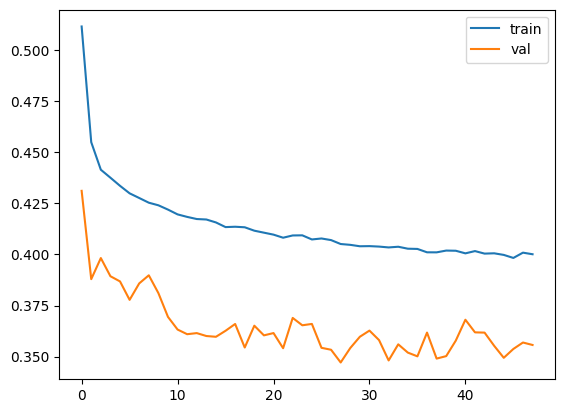

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(('train', 'val'))
plt.savefig(os.path.join(output_dir, "loss.pdf"))

## Predict and compute scores on validation set

In [20]:
# Prediction on validation set

print("VALIDATION\n")

y_pred = predict(log_mel_spec_list, val_file_idxs, model)


generate_output_file(y_pred, val_file_idxs, output_dir, file_list,
                       'predictions_validation', 'coarse', taxonomy)

prediction_file = os.path.join(output_dir, 'output_predictions_validation.csv')

df_dict = evaluate(prediction_file,
                  annotation_file,
                  taxonomy_file,
                  'coarse',
                   'validate')

micro_auprc, eval_df = micro_averaged_auprc(df_dict, return_df=True)
macro_auprc, class_auprc = macro_averaged_auprc(df_dict, return_classwise=True)

# Get index of first threshold that is at least 0.5
thresh_0pt5_idx = (eval_df['threshold'] >= 0.5).to_numpy().nonzero()[0][0]

print("Micro AUPRC:           {}".format(micro_auprc))
print("Micro F1-score (@0.5): {}".format(eval_df["F"][thresh_0pt5_idx]))
print("Macro AUPRC:           {}".format(macro_auprc))
print("Coarse Tag AUPRC:")

for coarse_id, auprc in class_auprc.items():
    print("      - {}: {}".format(coarse_id, auprc))

with open(os.path.join(output_dir, 'final_results_validation.txt'), 'w') as f:
    f.write("Micro AUPRC:           {}\n".format(micro_auprc))
    f.write("Micro F1-score (@0.5): {}\n".format(eval_df["F"][thresh_0pt5_idx]))
    f.write("Macro AUPRC:           {}\n".format(macro_auprc))
    f.write("Coarse Tag AUPRC:\n")
    for coarse_id, auprc in class_auprc.items():
        f.write("      - {}: {}\n".format(coarse_id, auprc))

VALIDATION

Micro AUPRC:           0.6145232383795827
Micro F1-score (@0.5): 0.5529308836395451
Macro AUPRC:           0.3681745957814433
Coarse Tag AUPRC:
      - 1: 0.7751769158855797
      - 2: 0.3383970886963229
      - 3: 0.18414510752931912
      - 4: 0.2824330753716959
      - 5: 0.5318597959329995
      - 6: 0.07506947342549426
      - 7: 0.7417077293771523
      - 8: 0.01660758003298232


## Predict on test set

In [21]:
y_pred = predict(log_mel_spec_list, test_file_idxs, model)


generate_output_file(y_pred, test_file_idxs, output_dir, file_list,
                       'predictions_test', 'coarse', taxonomy)

prediction_file = os.path.join(output_dir, 'output_predictions_test.csv')